In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv


In [2]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.8/430.8 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: narwhals
    Found existing installation: narwhals 1.48.1
    Uninstalling narwhals-1.48.1:
      Successfully uninstalled narwhals-1.48.1


In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

print(df.shape)
print(df.head())

(116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  


In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# --- 1) Load raw CSV (no scaling) ---
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

# Recode to 0=healthy/control, 1=cancer (Coimbra: 1=healthy, 2=cancer)
df["Classification"] = df["Classification"].replace({1: 0, 2: 1}).astype(int)

# Optional: nicer name if present
if "MCP.1" in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# --- 2) Variables to test (same as your table) ---
vars_to_test = ["Glucose", "HOMA", "Leptin", "Adiponectin", "Resistin"]
vars_to_test = [c for c in vars_to_test if c in df.columns]

# Split groups (do not mutate values)
g0 = df[df["Classification"] == 0]   # healthy/control
g1 = df[df["Classification"] == 1]   # cancer

def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

rows = []
for col in vars_to_test:
    x = g0[col].dropna()
    y = g1[col].dropna()

    # Mann–Whitney U (two-sided)
    U, p = stats.mannwhitneyu(x, y, alternative="two-sided")
    n0, n1 = len(x), len(y)

    # Effect size: rank-biserial correlation
    r_rb = 1 - (2 * U) / (n0 * n1)

    rows.append({
        "Variable": col,
        "Mean_Healthy": x.mean(),
        "Mean_Cancer": y.mean(),
        "Median_Healthy": x.median(),
        "Median_Cancer": y.median(),
        "U_Statistic": U,
        "p_value": p,
        "p_value_fmt": fmt_p(p),
        "rank_biserial_r": r_rb,
        "n_healthy": n0,
        "n_cancer": n1
    })

mw = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)

# Optional: multiple-testing correction (Bonferroni)
rej, p_adj, _, _ = multipletests(mw["p_value"].values, alpha=0.05, method="bonferroni")
mw["p_Bonferroni"] = p_adj
mw["p_Bonf_fmt"] = [fmt_p(v) for v in p_adj]
mw["sig_0.05_Bonf"] = rej

# Nice rounding for viewing/printing
display_cols = [
    "Variable", "Mean_Healthy", "Mean_Cancer",
    "Median_Healthy", "Median_Cancer",
    "U_Statistic", "p_value_fmt", "rank_biserial_r",
    "p_Bonf_fmt", "sig_0.05_Bonf", "n_healthy", "n_cancer"
]
print(mw[display_cols].round({
    "Mean_Healthy": 2, "Mean_Cancer": 2,
    "Median_Healthy": 2, "Median_Cancer": 2,
    "U_Statistic": 1, "rank_biserial_r": 3
}))


      Variable  Mean_Healthy  Mean_Cancer  Median_Healthy  Median_Cancer  \
0      Glucose         88.23       105.56           87.00          98.50   
1     Resistin         11.61        17.25            8.93          14.37   
2         HOMA          1.55         3.62            1.14           2.05   
3  Adiponectin         10.33        10.06            8.13           8.45   
4       Leptin         26.64        26.60           21.49          18.88   

   U_Statistic p_value_fmt  rank_biserial_r p_Bonf_fmt  sig_0.05_Bonf  \
0        783.5      <0.001            0.529     <0.001           True   
1       1103.0       0.002            0.337      0.009           True   
2       1127.0       0.003            0.323      0.014           True   
3       1610.0       0.766            0.032      1.000          False   
4       1652.0       0.949            0.007      1.000          False   

   n_healthy  n_cancer  
0         52        64  
1         52        64  
2         52        64  
3   

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# --- Load raw CSV (no scaling, no outlier edits) ---
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

# Recode: 0 = healthy/control, 1 = cancer (Coimbra: 1=healthy, 2=cancer)
df["Classification"] = df["Classification"].replace({1: 0, 2: 1}).astype(int)

# Clean column name if present
if "MCP.1" in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# Variables in the order you want
vars_to_test = ["Glucose", "HOMA", "Leptin", "Adiponectin", "Resistin"]
vars_to_test = [v for v in vars_to_test if v in df.columns]

# Split groups
g0 = df[df["Classification"] == 0]   # Healthy
g1 = df[df["Classification"] == 1]   # Cancer

def fmt_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

rows = []
for col in vars_to_test:
    x = g0[col].dropna()
    y = g1[col].dropna()

    # Mann–Whitney U (two-sided)
    U, p = stats.mannwhitneyu(x, y, alternative="two-sided")

    rows.append({
        "Variable": col,
        "Mean Healthy": x.mean(),
        "Mean Cancer": y.mean(),
        "U_Statistics": U,
        "P value": p
    })

# Build and pretty-print table exactly like your example
tbl = pd.DataFrame(rows)
tbl["Mean Healthy"] = tbl["Mean Healthy"].round(2)
tbl["Mean Cancer"]  = tbl["Mean Cancer"].round(2)
tbl["U_Statistics"] = tbl["U_Statistics"].round(1)
tbl["P value"]      = tbl["P value"].apply(fmt_p)

# Optional: sort by your preferred order (keeps the order we defined)
tbl = tbl.set_index("Variable").loc[vars_to_test].reset_index()

print("Variable\tMean Healthy\tMean Cancer\tU_Statistics\tP value")
for _, r in tbl.iterrows():
    print(f"{r['Variable']}\t{r['Mean Healthy']}\t{r['Mean Cancer']}\n\t{r['U_Statistics']}\n\t{r['P value']}")

# If you also want a clean DataFrame display or to save:
# display(tbl)
# tbl.to_csv("mann_whitney_table_raw.csv", index=False)


Variable	Mean Healthy	Mean Cancer	U_Statistics	P value
Glucose	88.23	105.56
	783.5
	<0.001
HOMA	1.55	3.62
	1127.0
	0.003
Leptin	26.64	26.6
	1652.0
	0.949
Adiponectin	10.33	10.06
	1610.0
	0.766
Resistin	11.61	17.25
	1103.0
	0.002


In [6]:
import pandas as pd
import numpy as np

# --- Load & prep (raw) ---
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")
df["Classification"] = df["Classification"].replace({1: 0, 2: 1}).astype(int)
if "MCP.1" in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# Variables to check/cap
vars_to_check = ["Glucose", "HOMA", "Leptin", "Adiponectin", "Resistin"]
vars_to_check = [v for v in vars_to_check if v in df.columns]

# --- Winsorization rule (adjust if needed) ---
LOW_Q, HIGH_Q = 0.01, 0.99   # 1st–99th percentile

def winsor_limits(s, low_q=LOW_Q, high_q=HIGH_Q):
    return s.quantile(low_q), s.quantile(high_q)

# 1) Detect outliers (no mutation)
rows = []
for col in vars_to_check:
    lo, hi = winsor_limits(df[col])
    all_below = int((df[col] < lo).sum())
    all_above = int((df[col] > hi).sum())

    g0 = df["Classification"] == 0   # Healthy
    g1 = df["Classification"] == 1   # Cancer

    rows.append({
        "Variable": col,
        "Lower_limit": lo,
        "Upper_limit": hi,
        "All_below": all_below,
        "All_above": all_above,
        "Healthy_below": int((df.loc[g0, col] < lo).sum()),
        "Healthy_above": int((df.loc[g0, col] > hi).sum()),
        "Cancer_below": int((df.loc[g1, col] < lo).sum()),
        "Cancer_above": int((df.loc[g1, col] > hi).sum())
    })

winsor_detection = pd.DataFrame(rows).round(3)
print("\n=== Winsorization-based outlier detection (no data changed) ===")
print(winsor_detection)

# 2) Create a winsorized COPY (do not overwrite df)
df_winsor = df.copy()
changed_counts = []
for col in vars_to_check:
    lo, hi = winsor_limits(df[col])
    before = df_winsor[col].copy()
    df_winsor[col] = np.clip(df_winsor[col], lo, hi)
    changed_counts.append({"Variable": col, "Values_capped": int((before != df_winsor[col]).sum())})

winsor_changes = pd.DataFrame(changed_counts)
print("\n=== How many values were capped (winsorized) ===")
print(winsor_changes)

# 3) (Optional) Summaries before/after for your appendix/table
def summarize_cols(frame, cols):
    out = []
    for c in cols:
        s = frame[c].dropna()
        out.append({
            "Variable": c,
            "n": s.size,
            "mean": s.mean(),
            "std": s.std(ddof=1),
            "min": s.min(),
            "q25": s.quantile(0.25),
            "median": s.median(),
            "q75": s.quantile(0.75),
            "max": s.max()
        })
    return pd.DataFrame(out)

summary_raw = summarize_cols(df, vars_to_check).round(3)
summary_win = summarize_cols(df_winsor, vars_to_check).round(3)

print("\n=== Summary (RAW) ===")
print(summary_raw)
print("\n=== Summary (WINSORIZED) ===")
print(summary_win)

# 4) (Optional) Save artifacts
# winsor_detection.to_csv("winsor_outlier_detection.csv", index=False)
# winsor_changes.to_csv("winsor_values_capped.csv", index=False)
# summary_raw.to_csv("summary_raw.csv", index=False)
# summary_win.to_csv("summary_winsorized.csv", index=False)
# df_winsor.to_csv("coimbra_winsorized.csv", index=False)



=== Winsorization-based outlier detection (no data changed) ===
      Variable  Lower_limit  Upper_limit  All_below  All_above  Healthy_below  \
0      Glucose       70.000      198.550          1          2              1   
1         HOMA        0.510       19.829          2          2              1   
2       Leptin        4.750       88.402          2          2              2   
3  Adiponectin        2.194       35.713          1          2              0   
4     Resistin        3.273       54.984          2          2              0   

   Healthy_above  Cancer_below  Cancer_above  
0              0             0             2  
1              0             1             2  
2              0             0             2  
3              2             1             0  
4              1             2             1  

=== How many values were capped (winsorized) ===
      Variable  Values_capped
0      Glucose              3
1         HOMA              4
2       Leptin            

In [7]:
import pandas as pd
import numpy as np

# ===============================
# 0) Load & prepare (RAW data)
# ===============================
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")
df["Classification"] = df["Classification"].replace({1: 0, 2: 1}).astype(int)
if "MCP.1" in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# Same variables you’ve been analyzing
vars_to_test = ["Glucose", "HOMA", "Leptin", "Adiponectin", "Resistin"]
vars_to_test = [v for v in vars_to_test if v in df.columns]

# Split groups
g_healthy = df[df["Classification"] == 0]
g_cancer  = df[df["Classification"] == 1]

# ===============================
# 1) Cliff's delta (δ)
#    δ = P(X>Y) - P(X<Y); ties contribute 0
#    Here, X = Cancer, Y = Healthy  -> δ>0 means Cancer higher
# ===============================
def cliffs_delta(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    # pairwise compare (n_x * n_y is small here, so O(n^2) is fine)
    diffs = x[:, None] - y[None, :]
    return (np.sum(diffs > 0) - np.sum(diffs < 0)) / (x.size * y.size)

# ===============================
# 2) Bootstrap 95% CI for δ
#    Stratified bootstrap to keep group sizes
# ===============================
rng = np.random.default_rng(42)

def cliffs_delta_ci(x, y, B=5000, rng=rng):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    deltas = np.empty(B, dtype=float)
    n_x, n_y = x.size, y.size
    for b in range(B):
        xb = x[rng.integers(0, n_x, n_x)]
        yb = y[rng.integers(0, n_y, n_y)]
        deltas[b] = cliffs_delta(xb, yb)
    lo, hi = np.quantile(deltas, [0.025, 0.975])
    return lo, hi

# ===============================
# 3) Build the table
# ===============================
rows = []
for v in vars_to_test:
    x = g_cancer[v].dropna().values    # Cancer
    y = g_healthy[v].dropna().values   # Healthy

    d = cliffs_delta(x, y)
    lo, hi = cliffs_delta_ci(x, y, B=5000, rng=rng)

    rows.append({
        "Biomarker": v,
        "Mean Healthy": y.mean(),
        "Mean Cancer": x.mean(),
        "Cliff's δ": d,
        "95% CI (low)": lo,
        "95% CI (high)": hi,
        "n_Healthy": y.size,
        "n_Cancer": x.size
    })

table_delta = pd.DataFrame(rows)

# Magnitude labels (Cliff, 1996 thresholds)
def cliff_magnitude(d):
    ad = abs(d)
    if ad < 0.147: return "negligible"
    if ad < 0.33:  return "small"
    if ad < 0.474: return "medium"
    return "large"

table_delta["Magnitude"] = table_delta["Cliff's δ"].apply(cliff_magnitude)

# Round nicely for manuscript
out_cols = ["Biomarker", "Mean Healthy", "Mean Cancer", "Cliff's δ",
            "95% CI (low)", "95% CI (high)", "Magnitude", "n_Healthy", "n_Cancer"]
print(table_delta[out_cols].round({
    "Mean Healthy": 2, "Mean Cancer": 2,
    "Cliff's δ": 3, "95% CI (low)": 3, "95% CI (high)": 3
}))

# Optional: save to CSV for your paper/supplement
# table_delta[out_cols].round(3).to_csv("cliffs_delta_with_95CI.csv", index=False)


     Biomarker  Mean Healthy  Mean Cancer  Cliff's δ  95% CI (low)  \
0      Glucose         88.23       105.56      0.529         0.350   
1         HOMA          1.55         3.62      0.323         0.118   
2       Leptin         26.64        26.60      0.007        -0.207   
3  Adiponectin         10.33        10.06      0.032        -0.178   
4     Resistin         11.61        17.25      0.337         0.130   

   95% CI (high)   Magnitude  n_Healthy  n_Cancer  
0          0.696       large         52        64  
1          0.519       small         52        64  
2          0.222  negligible         52        64  
3          0.248  negligible         52        64  
4          0.528      medium         52        64  


In [8]:
import pandas as pd
import numpy as np

# Load RAW Coimbra CSV
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")
df["Classification"] = df["Classification"].replace({1: 0, 2: 1}).astype(int)

# Normalize the name so it’s consistent everywhere
if "MCP.1" in df.columns and "MCP-1" not in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# Variables to report (now includes MCP-1)
vars_to_test = ["Glucose", "HOMA", "Leptin", "Adiponectin", "Resistin", "MCP-1"]
vars_to_test = [v for v in vars_to_test if v in df.columns]

# Split groups
g_healthy = df[df["Classification"] == 0]
g_cancer  = df[df["Classification"] == 1]

# Cliff's delta (Cancer vs Healthy; δ>0 ⇒ Cancer higher)
def cliffs_delta(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    diffs = x[:, None] - y[None, :]
    return (np.sum(diffs > 0) - np.sum(diffs < 0)) / (x.size * y.size)

# Bootstrap 95% CI
rng = np.random.default_rng(42)
def cliffs_delta_ci(x, y, B=5000, rng=rng):
    x = np.asarray(x, dtype=float); n_x = x.size
    y = np.asarray(y, dtype=float); n_y = y.size
    deltas = np.empty(B, float)
    for b in range(B):
        xb = x[rng.integers(0, n_x, n_x)]
        yb = y[rng.integers(0, n_y, n_y)]
        deltas[b] = cliffs_delta(xb, yb)
    return np.quantile(deltas, [0.025, 0.975])

def cliff_magnitude(d):
    ad = abs(d)
    if ad < 0.147: return "negligible"
    if ad < 0.33:  return "small"
    if ad < 0.474: return "medium"
    return "large"

rows = []
for v in vars_to_test:
    x = g_cancer[v].dropna().values     # Cancer
    y = g_healthy[v].dropna().values    # Healthy
    d = cliffs_delta(x, y)
    lo, hi = cliffs_delta_ci(x, y, B=5000, rng=rng)
    rows.append({
        "Biomarker": v,
        "Mean Healthy": y.mean(),
        "Mean Cancer": x.mean(),
        "Cliff's δ": d,
        "95% CI (low)": lo,
        "95% CI (high)": hi,
        "Magnitude": cliff_magnitude(d),
        "n_Healthy": y.size,
        "n_Cancer": x.size
    })

table_delta = pd.DataFrame(rows)
print(table_delta.round({
    "Mean Healthy": 2, "Mean Cancer": 2,
    "Cliff's δ": 3, "95% CI (low)": 3, "95% CI (high)": 3
}))

# If you just want the MCP-1 row:
if "MCP-1" in table_delta["Biomarker"].values:
    print("\nMCP-1 only:")
    print(table_delta[table_delta["Biomarker"]=="MCP-1"].round(3))


     Biomarker  Mean Healthy  Mean Cancer  Cliff's δ  95% CI (low)  \
0      Glucose         88.23       105.56      0.529         0.350   
1         HOMA          1.55         3.62      0.323         0.118   
2       Leptin         26.64        26.60      0.007        -0.207   
3  Adiponectin         10.33        10.06      0.032        -0.178   
4     Resistin         11.61        17.25      0.337         0.130   
5        MCP-1        499.73       563.02      0.073        -0.139   

   95% CI (high)   Magnitude  n_Healthy  n_Cancer  
0          0.696       large         52        64  
1          0.519       small         52        64  
2          0.222  negligible         52        64  
3          0.248  negligible         52        64  
4          0.528      medium         52        64  
5          0.283  negligible         52        64  

MCP-1 only:
  Biomarker  Mean Healthy  Mean Cancer  Cliff's δ  95% CI (low)  \
5     MCP-1       499.731      563.016      0.073        -0.139  

     Biomarker  Mean Healthy  Mean Cancer  Cliff's δ  95% CI (low)  \
0      Glucose         88.23       105.56      0.529         0.350   
1         HOMA          1.55         3.62      0.323         0.118   
2       Leptin         26.64        26.60      0.007        -0.207   
3  Adiponectin         10.33        10.06      0.032        -0.178   
4     Resistin         11.61        17.25      0.337         0.130   
5        MCP-1        499.73       563.02      0.073        -0.139   

   95% CI (high)   Magnitude  n_Healthy  n_Cancer  
0          0.696       large         52        64  
1          0.519       small         52        64  
2          0.222  negligible         52        64  
3          0.248  negligible         52        64  
4          0.528      medium         52        64  
5          0.283  negligible         52        64  


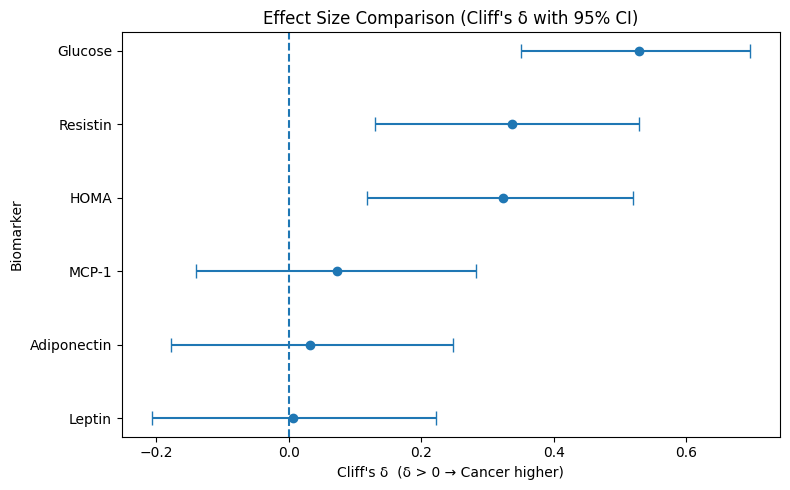

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== 1) Load & prep (RAW data) ====
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")
df["Classification"] = df["Classification"].replace({1: 0, 2: 1}).astype(int)
if "MCP.1" in df.columns and "MCP-1" not in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

vars_to_test = ["Glucose", "HOMA", "Leptin", "Adiponectin", "Resistin", "MCP-1"]
vars_to_test = [v for v in vars_to_test if v in df.columns]

g_healthy = df[df["Classification"] == 0]
g_cancer  = df[df["Classification"] == 1]

# ==== 2) Cliff's delta (Cancer vs Healthy; δ>0 ⇒ Cancer higher) ====
def cliffs_delta(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    diffs = x[:, None] - y[None, :]
    return (np.sum(diffs > 0) - np.sum(diffs < 0)) / (x.size * y.size)

# Bootstrap 95% CI
rng = np.random.default_rng(42)
def cliffs_delta_ci(x, y, B=5000):
    x = np.asarray(x, float); y = np.asarray(y, float)
    n_x, n_y = x.size, y.size
    deltas = np.empty(B)
    for b in range(B):
        xb = x[rng.integers(0, n_x, n_x)]
        yb = y[rng.integers(0, n_y, n_y)]
        deltas[b] = cliffs_delta(xb, yb)
    return np.quantile(deltas, [0.025, 0.975])

def cliff_magnitude(d):
    ad = abs(d)
    if ad < 0.147: return "negligible"
    if ad < 0.33:  return "small"
    if ad < 0.474: return "medium"
    return "large"

# Build table_delta
rows = []
for v in vars_to_test:
    x = g_cancer[v].dropna().values     # Cancer
    y = g_healthy[v].dropna().values    # Healthy
    d = cliffs_delta(x, y)
    lo, hi = cliffs_delta_ci(x, y, B=5000)
    rows.append({
        "Biomarker": v,
        "Mean Healthy": y.mean(),
        "Mean Cancer": x.mean(),
        "Cliff's δ": d,
        "95% CI (low)": lo,
        "95% CI (high)": hi,
        "Magnitude": cliff_magnitude(d),
        "n_Healthy": y.size,
        "n_Cancer": x.size
    })

table_delta = pd.DataFrame(rows)

# Print a rounded table
print(table_delta.round({
    "Mean Healthy": 2, "Mean Cancer": 2,
    "Cliff's δ": 3, "95% CI (low)": 3, "95% CI (high)": 3
}))

# ==== 3) Plot directly from table_delta (keeps figure consistent with table) ====
td = table_delta.sort_values("Cliff's δ")  # or keep your own order

labels = td["Biomarker"].tolist()
delta  = td["Cliff's δ"].to_numpy()
ci_lo  = td["95% CI (low)"].to_numpy()
ci_hi  = td["95% CI (high)"].to_numpy()
xerr   = np.vstack([delta - ci_lo, ci_hi - delta])

plt.figure(figsize=(8, 5))
plt.errorbar(delta, labels, xerr=xerr, fmt='o', capsize=5)
plt.axvline(0, linestyle="--")
plt.xlabel("Cliff's δ  (δ > 0 → Cancer higher)")
plt.ylabel("Biomarker")
plt.title("Effect Size Comparison (Cliff's δ with 95% CI)")
plt.tight_layout()
plt.show()

# Optional saves:
# table_delta.round(3).to_csv("cliffs_delta_with_95CI.csv", index=False)
# plt.savefig("cliffs_delta_plot.png", dpi=300, bbox_inches="tight")


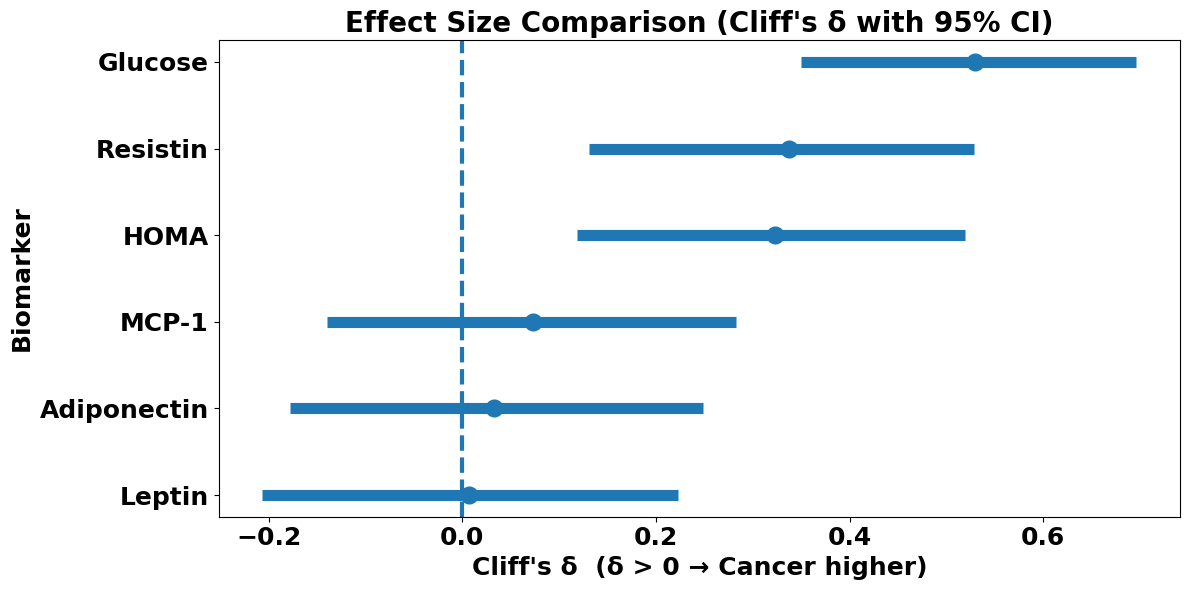

In [10]:
# --- Assumes you already built `table_delta` as before ---
import numpy as np
import matplotlib.pyplot as plt

td = table_delta.sort_values("Cliff's δ")  # or keep your own order

labels = td["Biomarker"].tolist()
delta  = td["Cliff's δ"].to_numpy()
ci_lo  = td["95% CI (low)"].to_numpy()
ci_hi  = td["95% CI (high)"].to_numpy()

ypos = np.arange(len(labels))

plt.figure(figsize=(12, 6))

# Thick CI bars
for y, lo, hi in zip(ypos, ci_lo, ci_hi):
    plt.hlines(y, lo, hi, linewidth=8)  # << wider bars

# δ points
plt.plot(delta, ypos, 'o', markersize=12)

# Zero reference line
plt.axvline(0, linestyle='--', linewidth=3)

# Ticks/labels/title (size 18, bold)
plt.yticks(ypos, labels, fontsize=18, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.xlabel("Cliff's δ  (δ > 0 → Cancer higher)", fontsize=18, fontweight='bold')
plt.ylabel("Biomarker", fontsize=18, fontweight='bold')
plt.title("Effect Size Comparison (Cliff's δ with 95% CI)", fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()


/tmp/ipykernel_13/2147612295.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


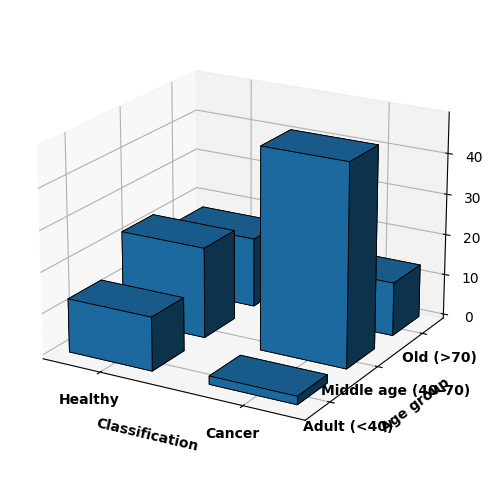

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# ----------------------------
# 1) Start from your dataframe
# ----------------------------
# If you already have df, keep this commented.
# df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

# Make sure Classification is labeled nicely
# Coimbra: 1=healthy, 2=cancer (sometimes you recoded to 0/1; both handled here)
cls = df["Classification"]
if set(np.unique(cls)) <= {0, 1}:  # 0/1 coding
    lab = cls.map({0: "Healthy", 1: "Cancer"})
else:  # 1/2 coding
    lab = cls.map({1: "Healthy", 2: "Cancer"})
df = df.assign(Classification_label=lab)

# ----------------------------
# 2) Create Age groups
# ----------------------------
age_bins   = [0, 40, 70, np.inf]
age_labels = ["Adult (<40)", "Middle age (40–70)", "Old (>70)"]
df["Age_group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)

# ----------------------------
# 3) Build contingency table
# ----------------------------
ct = pd.crosstab(df["Classification_label"], df["Age_group"])

# Ensure order on axes
class_order = ["Healthy", "Cancer"]
age_order   = age_labels

ct = ct.reindex(index=class_order, columns=age_order, fill_value=0)

# ----------------------------
# 4) 3D bar plot
# ----------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# grid of bar positions
xpos, ypos = np.meshgrid(np.arange(len(class_order)),
                         np.arange(len(age_order)),
                         indexing="ij")

xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos, dtype=float)

dx = dy = 0.6  # bar width/depth
dz = ct.values.ravel().astype(float)

# draw bars (no explicit color needed)
ax.bar3d(xpos - dx/2, ypos - dy/2, zpos, dx, dy, dz, shade=True, edgecolor="black", linewidth=0.6)

# ticks & labels
ax.set_xticks(np.arange(len(class_order)))
ax.set_xticklabels(class_order, fontweight="bold")
ax.set_yticks(np.arange(len(age_order)))
ax.set_yticklabels(age_order, fontweight="bold")

ax.set_xlabel("Classification", fontweight="bold")
ax.set_ylabel("Age group", fontweight="bold")
ax.set_zlabel("Count", fontweight="bold")

# camera angle similar to your image
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show()


/tmp/ipykernel_13/1187723660.py:64: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  try: ax.dist = 7


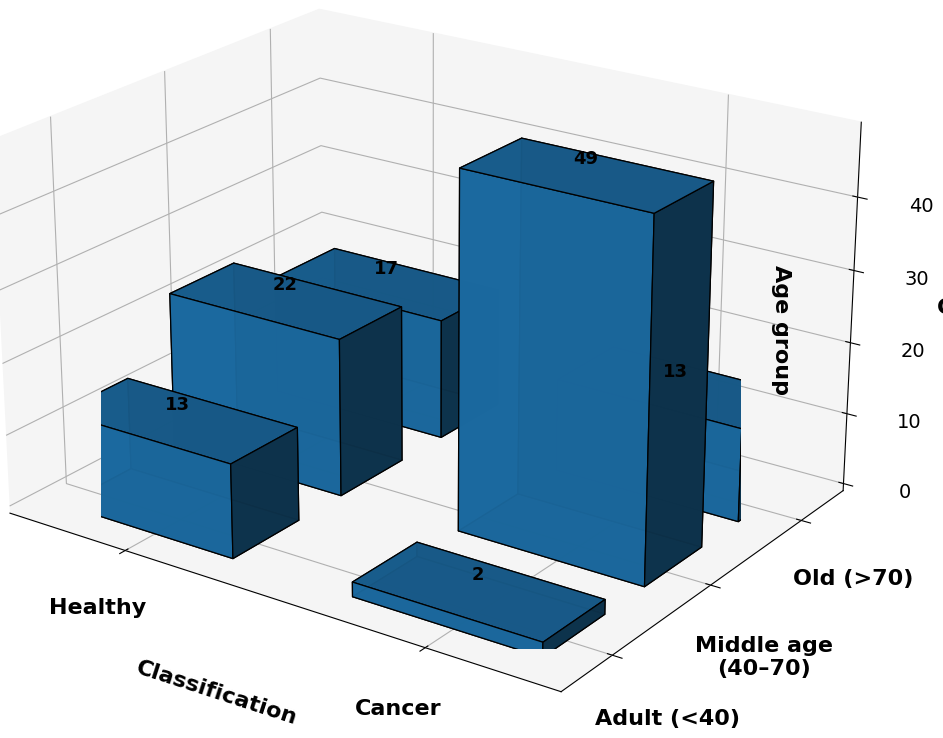

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---- DATA (use your existing df if it's already loaded) ----
# df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

cl = df["Classification"]
if set(np.unique(cl)) <= {0, 1}:
    df["Classification_label"] = cl.map({0: "Healthy", 1: "Cancer"})
else:
    df["Classification_label"] = cl.map({1: "Healthy", 2: "Cancer"})

age_bins   = [0, 40, 70, np.inf]
age_labels = ["Adult (<40)", "Middle age\n(40–70)", "Old (>70)"]  # wrap
df["Age_group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)

class_order = ["Healthy", "Cancer"]
ct = (pd.crosstab(df["Classification_label"], df["Age_group"])
        .reindex(index=class_order, columns=age_labels, fill_value=0))

# ---- PLOT ----
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# bars
xpos, ypos = np.meshgrid(np.arange(len(class_order)),
                         np.arange(len(age_labels)), indexing="ij")
xpos = xpos.ravel(); ypos = ypos.ravel()
zpos = np.zeros_like(xpos, float)
dx = dy = 0.6
dz = ct.values.ravel().astype(float)

ax.bar3d(xpos - dx/2, ypos - dy/2, zpos, dx, dy, dz,
         shade=True, edgecolor="black", linewidth=0.9, alpha=0.95)

# ticks
ax.set_xticks(np.arange(len(class_order)))
ax.set_xticklabels(class_order, fontsize=16, fontweight="bold")
ax.set_yticks(np.arange(len(age_labels)))
ax.set_yticklabels(age_labels, fontsize=16, fontweight="bold")
ax.tick_params(axis='x', pad=12)   # push tick labels away from axis
ax.tick_params(axis='y', pad=14)
ax.tick_params(axis='z', pad=10, labelsize=14)

# >>> X label BACK ON THE AXIS (inside), with safe spacing
ax.set_xlabel("Classification", fontsize=16, fontweight="bold", labelpad=18)

# Keep Z label on-axis
ax.set_zlabel("Count", fontsize=16, fontweight="bold", labelpad=14)
ax.zaxis.set_rotate_label(False)

# Put Y label OUTSIDE to avoid overlap with wrapped tick text
ax.set_ylabel("")                    # remove on-axis Y label
ax.yaxis.label.set_visible(False)
plt.subplots_adjust(left=0.12, right=0.85, bottom=0.18, top=0.98)
bbox = ax.get_position()
fig.text(bbox.x1 + 0.03, (bbox.y0 + bbox.y1)/2, "Age group",
         rotation=-90, va="center", ha="left", fontsize=16, fontweight="bold")

# camera & styling
ax.view_init(elev=22, azim=-55)
try: ax.dist = 7
except Exception: pass
ax.set_box_aspect((1.5, 1.2, 0.9))
for a in (ax.xaxis, ax.yaxis, ax.zaxis):
    a.set_pane_color((0.96, 0.96, 0.96, 1.0))

# annotate counts
for (x, y, h) in zip(xpos, ypos, dz):
    if h > 0:
        ax.text(x, y, h + 1.0, f"{int(h)}",
                ha="center", va="bottom", fontsize=13, fontweight="bold")

plt.show()


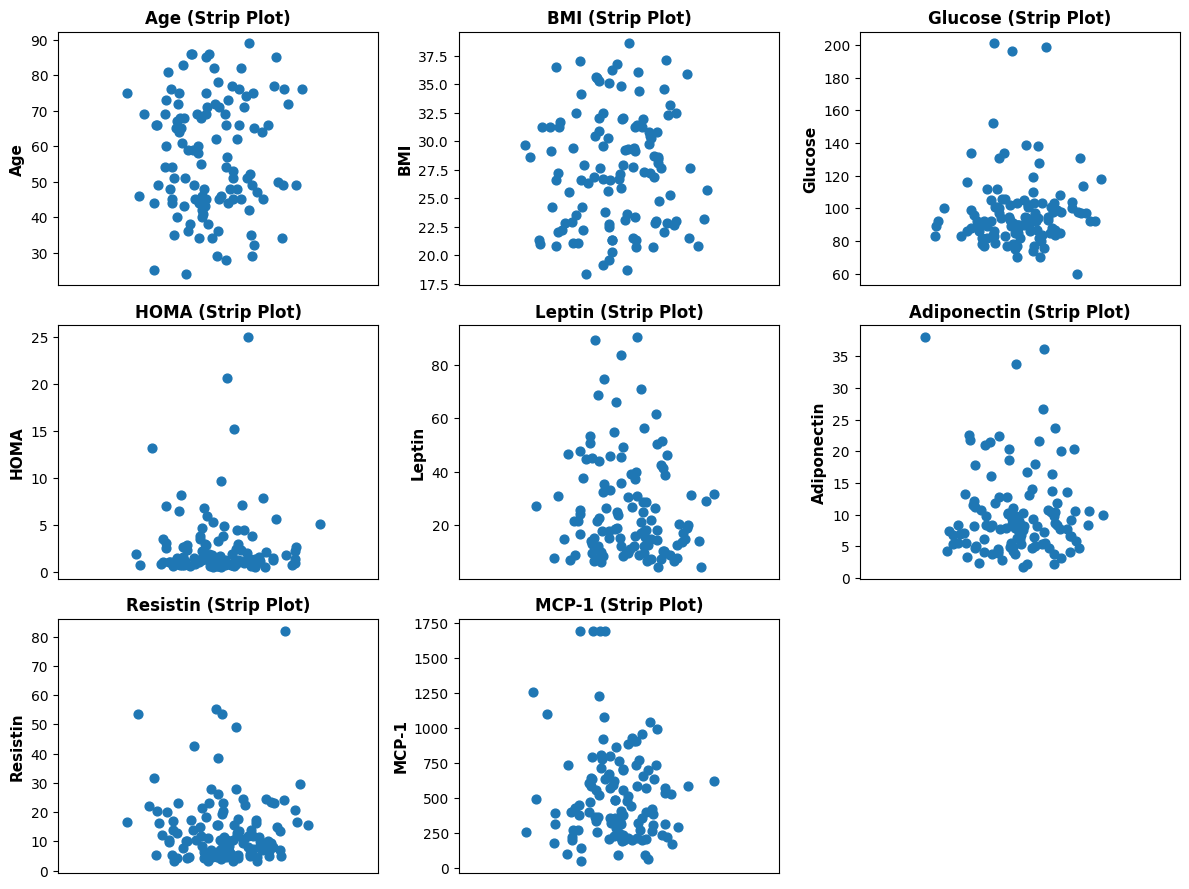

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

# 2) Fix column name for plotting: MCP.1 -> MCP-1
if "MCP.1" in df.columns and "MCP-1" not in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# 3) Variables to plot (adjust order if you like)
features = ["Age", "BMI", "Glucose", "HOMA", "Leptin",
            "Adiponectin", "Resistin", "MCP-1"]
features = [c for c in features if c in df.columns]  # guard

# 4) Make strip plots (jittered vertical scatter)
rows, cols = 3, 3  # 8 plots will fit (last cell blank)
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
axes = np.array(axes).reshape(-1)

for ax_idx, col in enumerate(features):
    ax = axes[ax_idx]
    y = df[col].dropna().values

    # small horizontal jitter around x=0 so points don't overlap
    x = 0 + 0.08 * np.random.randn(len(y))

    ax.scatter(x, y, s=40)  # no color specified by default
    ax.set_title(f"{col} (Strip Plot)", fontsize=12, fontweight="bold")
    ax.set_ylabel(col, fontsize=11, fontweight="bold")
    ax.set_xticks([])
    ax.set_xlim(-0.35, 0.35)  # keeps a nice narrow strip
    ax.grid(False)

# Hide any unused subplot(s)
for k in range(len(features), rows*cols):
    fig.delaxes(axes[k])

fig.tight_layout()
plt.savefig("biomarker_stripplots.png", dpi=300, bbox_inches="tight")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert

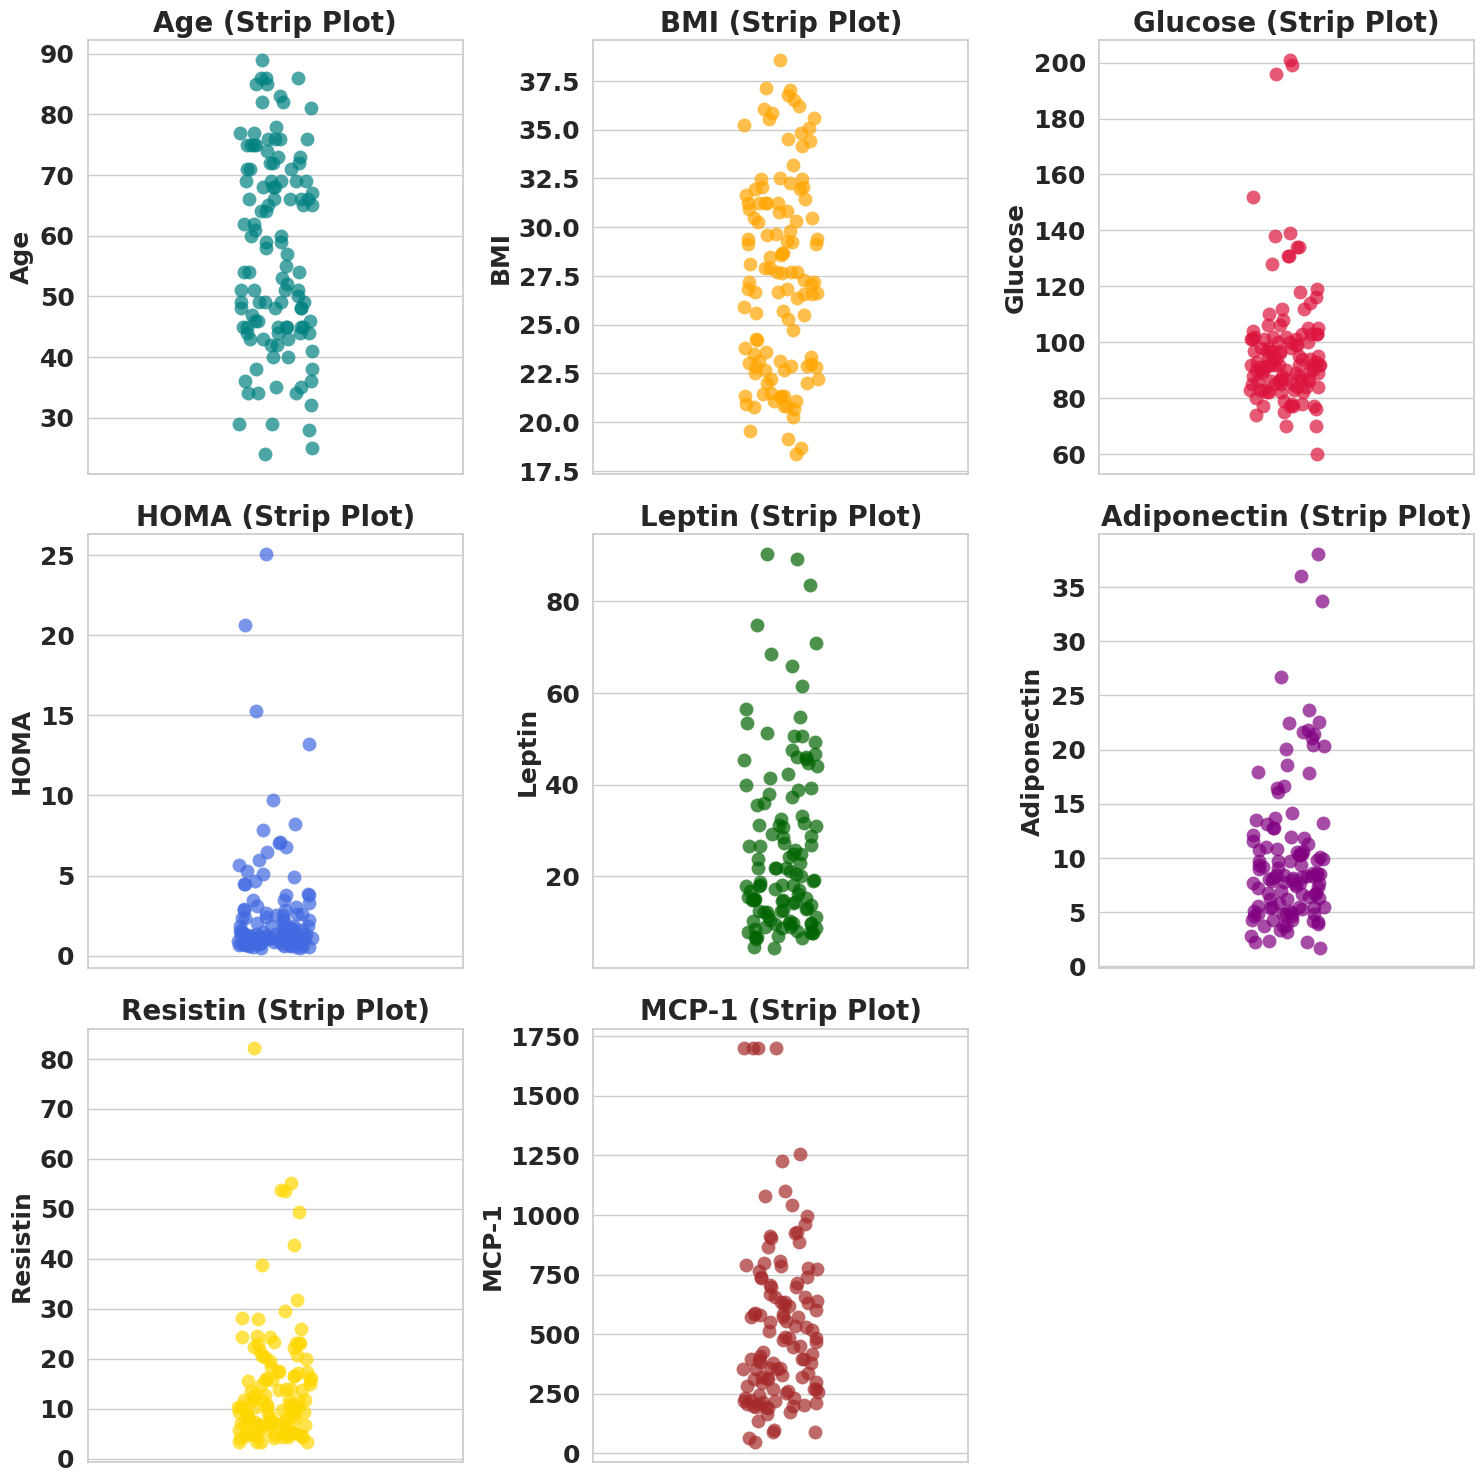

In [14]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load your data (adjust path if needed) ---
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

# Rename for nicer labels
if "MCP.1" in df.columns and "MCP-1" not in df.columns:
    df = df.rename(columns={"MCP.1": "MCP-1"})

# Variables to plot
independent_vars = [
    "Age","BMI","Glucose","HOMA","Leptin","Adiponectin","Resistin","MCP-1"
]
independent_vars = [v for v in independent_vars if v in df.columns]

# Style
sns.set_theme(style="whitegrid")  # keep background subtle
palette = ["teal", "orange", "crimson", "royalblue",
           "darkgreen", "purple", "gold", "brown"]

# Grid size (3 columns)
cols = 3
rows = math.ceil(len(independent_vars) / cols)

plt.figure(figsize=(15, 5*rows))

for i, col in enumerate(independent_vars, 1):
    plt.subplot(rows, cols, i)

    # one-category strip (vertical) with jitter
    sns.stripplot(
        y=df[col],
        color=palette[(i-1) % len(palette)],  # cycle colors cleanly
        jitter=True, size=10, alpha=0.7
    )

    # Titles/labels in bold with larger fonts
    plt.title(f"{col} (Strip Plot)", fontweight="bold", fontsize=20)
    plt.ylabel(col, fontweight="bold", fontsize=18)
    plt.xlabel("")  # no x label for the strip
    plt.yticks(fontweight="bold", fontsize=18)

    # Clean up x-axis (single category)
    plt.xticks([])
    plt.xlim(-0.5, 0.5)

plt.tight_layout()
plt.show()


In [15]:
X = df.drop(columns=['Classification'])
y = df['Classification']

print(X.shape)
print(y.value_counts())


(116, 9)
Classification
2    64
1    52
Name: count, dtype: int64


In [16]:
from sklearn.metrics import make_scorer, accuracy_score


In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score


In [18]:
# 1. Load the data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

print(df.shape)
print(df.head())

# 2. Split into features and target
X = df.drop(columns=['Classification'])
y = df['Classification']

print("Class counts:")
print(y.value_counts())

# 3. Build pipeline: scaler + logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# 4. Define stratified k-fold cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# 5. Evaluate with accuracy
scores = cross_val_score(
    pipe,
    X,
    y,
    cv=cv,
    scoring='accuracy'
)

print("Accuracy per fold:", scores)
print("Mean accuracy:", scores.mean())
print("Std deviation:", scores.std())

# 6. (Optional) Evaluate F1 and AUC
f1_scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
print("F1 per fold:", f1_scores)
print("Mean F1:", f1_scores.mean())

auc_scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
print("AUC per fold:", auc_scores)
print("Mean AUC:", auc_scores.mean())


(116, 10)
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
Class counts:
Classification
2    64
1    52
Name: count, dtype: int64
Accuracy per fold: [0.625      0.7826087  0.60869565 0.7826087  0.69565217]
Mean accuracy: 0.6989130434782609
Std deviation: 0.07432748259686417
F1 per fold: [0.52631579 0.76190476 0.47058824 0.7826087  0.66666667]
Mean F1: 0.6416168297982808
AUC per fold: [

In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y = df['Classification']

print("Original class counts:\n", y.value_counts(), "\n")

# 2. Recode y so that classes are 0 and 1 (required by XGBoost)
# Map: 1 -> 0, 2 -> 1
y_bin = y.replace({1: 0, 2: 1})

print("Re-coded class counts (0/1):\n", y_bin.value_counts(), "\n")

# 3. Define 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define models
models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 5. Define metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

results = []

# 6. Loop over models and evaluate with 5-fold CV
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    cv_results = cross_validate(
        pipe,
        X,
        y_bin,           # use the recoded labels
        cv=cv,
        scoring=scoring
    )
    
    results.append({
        "Model": name,
        "Accuracy": cv_results['test_accuracy'].mean(),
        "ROC-AUC": cv_results['test_roc_auc'].mean(),
        "Precision": cv_results['test_precision'].mean(),
        "Re-call": cv_results['test_recall'].mean(),
        "F1 score": cv_results['test_f1'].mean()
    })

# 7. Create results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print(results_df.to_string(index=False))


Original class counts:
 Classification
2    64
1    52
Name: count, dtype: int64 

Re-coded class counts (0/1):
 Classification
1    64
0    52
Name: count, dtype: int64 

         Model  Accuracy  ROC-AUC  Precision  Re-call  F1 score
           KNN  0.784420 0.823788   0.820779 0.797436  0.806400
           SVM  0.732609 0.854359   0.752179 0.798718  0.768405
            RF  0.723913 0.789312   0.745101 0.782051  0.761061
       XGBoost  0.723913 0.756853   0.731905 0.780769  0.753319
Gradient Boost  0.723551 0.806177   0.761172 0.750000  0.750710
      AdaBoost  0.656159 0.693427   0.689286 0.703846  0.694450


In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier  # if this errors, install or comment XGBoost out

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y = df['Classification']

print("Original class counts:\n", y.value_counts(), "\n")

# 2. Recode y to 0/1 for XGBoost compatibility (1 -> 0, 2 -> 1)
y_bin = y.replace({1: 0, 2: 1})

print("Re-coded class counts (0/1):\n", y_bin.value_counts(), "\n")

# 3. Define 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define models
models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 5. Define metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

results = []

# 6. Loop over models and evaluate with 5-fold CV
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    cv_results = cross_validate(
        pipe,
        X,
        y_bin,
        cv=cv,
        scoring=scoring
    )
    
    # Helper to create "mean ± sd" strings
    def fmt(metric_name):
        scores = cv_results[f"test_{metric_name}"]
        return f"{scores.mean():.4f} ± {scores.std():.4f}"
    
    results.append({
        "Model": name,
        "Accuracy": fmt('accuracy'),
        "ROC-AUC": fmt('roc_auc'),
        "Precision": fmt('precision'),
        "Re-call": fmt('recall'),
        "F1 score": fmt('f1')
    })

# 7. Create and show results table
results_df = pd.DataFrame(results)
# Optional: sort by mean accuracy (extract float before '±')
results_df


Original class counts:
 Classification
2    64
1    52
Name: count, dtype: int64 

Re-coded class counts (0/1):
 Classification
1    64
0    52
Name: count, dtype: int64 



,Model,Accuracy,ROC-AUC,Precision,Re-call,F1 score
0,SVM,0.7326 ± 0.0643,0.8544 ± 0.0615,0.7522 ± 0.0883,0.7987 ± 0.0765,0.7684 ± 0.0421
1,RF,0.7239 ± 0.1055,0.7893 ± 0.1241,0.7451 ± 0.1028,0.7821 ± 0.0550,0.7611 ± 0.0756
2,AdaBoost,0.6562 ± 0.0900,0.6934 ± 0.1048,0.6893 ± 0.0927,0.7038 ± 0.0726,0.6944 ± 0.0743
3,Gradient Boost,0.7236 ± 0.1164,0.8062 ± 0.0902,0.7612 ± 0.1272,0.7500 ± 0.1018,0.7507 ± 0.0979
4,XGBoost,0.7239 ± 0.1311,0.7569 ± 0.1276,0.7319 ± 0.1081,0.7808 ± 0.1498,0.7533 ± 0.1225
5,KNN,0.7844 ± 0.0728,0.8238 ± 0.0595,0.8208 ± 0.0903,0.7974 ± 0.0348,0.8064 ± 0.0516


In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier  # if this errors, install or comment XGBoost out

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y = df['Classification']

print("Original class counts:\n", y.value_counts(), "\n")

# 2. Recode y to 0/1 for XGBoost compatibility (1 -> 0, 2 -> 1)
y_bin = y.replace({1: 0, 2: 1})

print("Re-coded class counts (0/1):\n", y_bin.value_counts(), "\n")

# 3. Define 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define models
models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "RF": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# 5. Define metrics (add neg_brier_score)
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'brier': 'neg_brier_score'   # sklearn uses NEGATIVE Brier internally
}

results = []

# 6. Loop over models and evaluate with 5-fold CV
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    cv_results = cross_validate(
        pipe,
        X,
        y_bin,
        cv=cv,
        scoring=scoring
    )
    
    # Helper to create "mean ± sd" strings
    def fmt(scores):
        return f"{scores.mean():.4f} ± {scores.std():.4f}"
    
    acc_scores   = cv_results['test_accuracy']
    auc_scores   = cv_results['test_roc_auc']
    prec_scores  = cv_results['test_precision']
    rec_scores   = cv_results['test_recall']
    f1_scores    = cv_results['test_f1']
    # Convert back to positive Brier
    brier_scores = -cv_results['test_brier']
    
    results.append({
        "Model": name,
        "Accuracy":  fmt(acc_scores),
        "ROC-AUC":   fmt(auc_scores),
        "Precision": fmt(prec_scores),
        "Re-call":   fmt(rec_scores),
        "F1 score":  fmt(f1_scores),
        "Brier":     fmt(brier_scores)
    })

# 7. Create and show results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


Original class counts:
 Classification
2    64
1    52
Name: count, dtype: int64 

Re-coded class counts (0/1):
 Classification
1    64
0    52
Name: count, dtype: int64 

         Model        Accuracy         ROC-AUC       Precision         Re-call        F1 score           Brier
           SVM 0.7326 ± 0.0643 0.8544 ± 0.0615 0.7522 ± 0.0883 0.7987 ± 0.0765 0.7684 ± 0.0421 0.1729 ± 0.0369
            RF 0.7239 ± 0.1055 0.7893 ± 0.1241 0.7451 ± 0.1028 0.7821 ± 0.0550 0.7611 ± 0.0756 0.1847 ± 0.0479
      AdaBoost 0.6562 ± 0.0900 0.6934 ± 0.1048 0.6893 ± 0.0927 0.7038 ± 0.0726 0.6944 ± 0.0743 0.2281 ± 0.0098
Gradient Boost 0.7236 ± 0.1164 0.8062 ± 0.0902 0.7612 ± 0.1272 0.7500 ± 0.1018 0.7507 ± 0.0979 0.2131 ± 0.1016
       XGBoost 0.7239 ± 0.1311 0.7569 ± 0.1276 0.7319 ± 0.1081 0.7808 ± 0.1498 0.7533 ± 0.1225 0.2216 ± 0.1071
           KNN 0.7844 ± 0.0728 0.8238 ± 0.0595 0.8208 ± 0.0903 0.7974 ± 0.0348 0.8064 ± 0.0516 0.1684 ± 0.0253


In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y = df['Classification']

# Recode labels: 1 -> 0, 2 -> 1 (like before)
y_bin = y.replace({1: 0, 2: 1})

# 2. Define model (use your chosen one)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 3. 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Thresholds τ to test
taus = [0.1, 0.2, 0.3]

# 4. Storage for per-fold metrics
metrics_per_tau = {
    tau: {
        "coverage": [],
        "accuracy": [],
        "recall": [],
        "precision": []
    } for tau in taus
}

# 5. Cross-validation loop
for train_idx, test_idx in cv.split(X, y_bin):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_bin.iloc[train_idx], y_bin.iloc[test_idx]
    
    pipe.fit(X_train, y_train)
    
    # Predicted probabilities
    proba = pipe.predict_proba(X_test)
    # Predicted class
    y_pred = pipe.predict(X_test)
    # Max confidence per sample
    max_conf = proba.max(axis=1)
    
    for tau in taus:
        # Select only predictions with confidence >= τ
        mask = max_conf >= tau
        
        # Coverage: fraction of samples where we make a prediction
        coverage = mask.mean()
        
        if coverage == 0:
            # No predictions made at this tau in this fold
            continue
        
        y_true_sel = y_test[mask]
        y_pred_sel = y_pred[mask]
        
        acc = accuracy_score(y_true_sel, y_pred_sel)
        rec = recall_score(y_true_sel, y_pred_sel)
        prec = precision_score(y_true_sel, y_pred_sel)
        
        metrics_per_tau[tau]["coverage"].append(coverage)
        metrics_per_tau[tau]["accuracy"].append(acc)
        metrics_per_tau[tau]["recall"].append(rec)
        metrics_per_tau[tau]["precision"].append(prec)

# 6. Build "mean ± sd" table

rows = []

def fmt(arr):
    arr = np.array(arr)
    return f"{arr.mean():.3f} ± {arr.std():.3f}"

for tau in taus:
    m = metrics_per_tau[tau]
    rows.append({
        "τ": tau,
        "Coverage (mean ± sd)": fmt(m["coverage"]),
        "Accuracy (mean ± sd)": fmt(m["accuracy"]),
        "Recall (mean ± sd)": fmt(m["recall"]),
        "Precision (mean ± sd)": fmt(m["precision"])
    })

results_tau = pd.DataFrame(rows)
print(results_tau.to_string(index=False))


  τ Coverage (mean ± sd) Accuracy (mean ± sd) Recall (mean ± sd) Precision (mean ± sd)
0.1        1.000 ± 0.000        0.784 ± 0.073      0.797 ± 0.035         0.821 ± 0.090
0.2        1.000 ± 0.000        0.784 ± 0.073      0.797 ± 0.035         0.821 ± 0.090
0.3        1.000 ± 0.000        0.784 ± 0.073      0.797 ± 0.035         0.821 ± 0.090


In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y = df['Classification']

# Recode labels: 1 -> 0, 2 -> 1
y_bin = y.replace({1: 0, 2: 1})

# 2. Model (same as before – you can change to SVM etc.)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 3. 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

taus = [0.1, 0.2, 0.3]

metrics_per_tau = {
    tau: {
        "coverage": [],
        "accuracy": [],
        "recall": [],
        "precision": []
    } for tau in taus
}

# 4. CV loop
for train_idx, test_idx in cv.split(X, y_bin):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_bin.iloc[train_idx], y_bin.iloc[test_idx]
    
    pipe.fit(X_train, y_train)
    
    proba = pipe.predict_proba(X_test)
    p_pos = proba[:, 1]                     # probability of class 1 (positive)
    
    # confidence as distance from 0.5
    conf = np.abs(p_pos - 0.5)
    
    y_pred = (p_pos >= 0.5).astype(int)    # normal 0.5 decision boundary
    
    for tau in taus:
        mask = conf >= tau                 # only keep confident predictions
        
        coverage = mask.mean()
        if coverage == 0:
            # no predictions at this tau in this fold
            continue
        
        y_true_sel = y_test[mask]
        y_pred_sel = y_pred[mask]
        
        acc = accuracy_score(y_true_sel, y_pred_sel)
        rec = recall_score(y_true_sel, y_pred_sel)
        prec = precision_score(y_true_sel, y_pred_sel)
        
        metrics_per_tau[tau]["coverage"].append(coverage)
        metrics_per_tau[tau]["accuracy"].append(acc)
        metrics_per_tau[tau]["recall"].append(rec)
        metrics_per_tau[tau]["precision"].append(prec)

# 5. Build mean ± sd table

rows = []

def fmt(arr):
    arr = np.array(arr)
    return f"{arr.mean():.3f} ± {arr.std():.3f}"

for tau in taus:
    m = metrics_per_tau[tau]
    rows.append({
        "τ": tau,
        "Coverage (mean ± sd)": fmt(m["coverage"]),
        "Accuracy (mean ± sd)": fmt(m["accuracy"]),
        "Recall (mean ± sd)": fmt(m["recall"]),
        "Precision (mean ± sd)": fmt(m["precision"])
    })

results_tau = pd.DataFrame(rows)
print(results_tau.to_string(index=False))


  τ Coverage (mean ± sd) Accuracy (mean ± sd) Recall (mean ± sd) Precision (mean ± sd)
0.1        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070
0.2        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070
0.3        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070


In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y = df['Classification']

# Recode labels: 1 -> 0, 2 -> 1
y_bin = y.replace({1: 0, 2: 1})

# 2. Model (KNN as before)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 3. 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

taus = [0.1, 0.2, 0.3]

metrics_per_tau = {
    tau: {
        "coverage": [],
        "accuracy": [],
        "recall": [],
        "precision": [],
        "brier": []
    } for tau in taus
}

# 4. CV loop
for train_idx, test_idx in cv.split(X, y_bin):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_bin.iloc[train_idx], y_bin.iloc[test_idx]
    
    pipe.fit(X_train, y_train)
    
    proba = pipe.predict_proba(X_test)
    p_pos = proba[:, 1]                     # probability of class 1 (positive)
    
    # confidence as distance from 0.5
    conf = np.abs(p_pos - 0.5)
    
    # normal prediction at 0.5 threshold
    y_pred = (p_pos >= 0.5).astype(int)
    
    for tau in taus:
        mask = conf >= tau                 # only keep confident predictions
        
        coverage = mask.mean()
        if coverage == 0:
            continue
        
        y_true_sel = y_test[mask]
        y_pred_sel = y_pred[mask]
        p_pos_sel  = p_pos[mask]
        
        acc = accuracy_score(y_true_sel, y_pred_sel)
        rec = recall_score(y_true_sel, y_pred_sel)
        prec = precision_score(y_true_sel, y_pred_sel)
        brier = brier_score_loss(y_true_sel, p_pos_sel)
        
        metrics_per_tau[tau]["coverage"].append(coverage)
        metrics_per_tau[tau]["accuracy"].append(acc)
        metrics_per_tau[tau]["recall"].append(rec)
        metrics_per_tau[tau]["precision"].append(prec)
        metrics_per_tau[tau]["brier"].append(brier)

# 5. Build mean ± sd table

rows = []

def fmt(arr):
    arr = np.array(arr)
    return f"{arr.mean():.3f} ± {arr.std():.3f}"

for tau in taus:
    m = metrics_per_tau[tau]
    rows.append({
        "τ": tau,
        "Coverage (mean ± sd)": fmt(m["coverage"]),
        "Accuracy (mean ± sd)": fmt(m["accuracy"]),
        "Recall (mean ± sd)": fmt(m["recall"]),
        "Precision (mean ± sd)": fmt(m["precision"]),
        "Brier score (mean ± sd)": fmt(m["brier"])
    })

results_tau = pd.DataFrame(rows)
print(results_tau.to_string(index=False))


  τ Coverage (mean ± sd) Accuracy (mean ± sd) Recall (mean ± sd) Precision (mean ± sd) Brier score (mean ± sd)
0.1        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070           0.110 ± 0.054
0.2        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070           0.110 ± 0.054
0.3        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070           0.110 ± 0.054


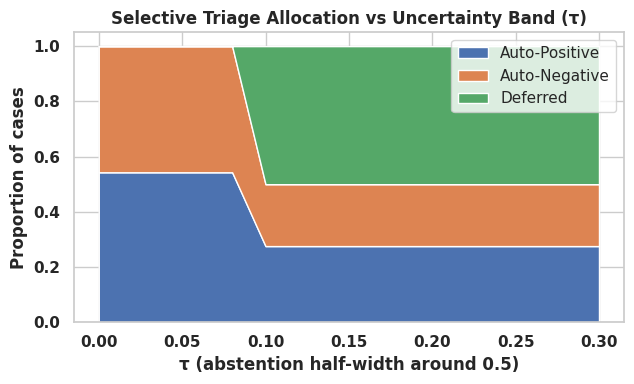

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# X = df.drop(columns=['Classification'])
# y_bin = df['Classification'].replace({1: 0, 2: 1})

# 1. Define model and pipeline (KNN as in your findings)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 2. Get out-of-fold predicted probabilities using 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

probs = cross_val_predict(
    pipe,
    X,
    y_bin,
    cv=cv,
    method="predict_proba"
)

# Probability of positive class
p = probs[:, 1]

# Hard predictions at 0.5 threshold
yhat = (p >= 0.5).astype(int)

# 3. Scan τ from 0.00 to 0.30 (like your example, 16 points)
taus = np.linspace(0.00, 0.30, 16)

auto_pos, auto_neg, deferred = [], [], []

for tau in taus:
    # Keep only high-confidence predictions: |p - 0.5| >= τ
    keep = np.abs(p - 0.5) >= tau

    # Proportion of all cases that are:
    # - auto-labeled positive
    # - auto-labeled negative
    # - deferred (no decision)
    auto_pos.append(((keep) & (yhat == 1)).mean())
    auto_neg.append(((keep) & (yhat == 0)).mean())
    deferred.append((~keep).mean())

# 4. Plot stackplot
plt.figure(figsize=(6.5, 4))
plt.stackplot(taus, auto_pos, auto_neg, deferred,
              labels=['Auto-Positive', 'Auto-Negative', 'Deferred'])

plt.title('Selective Triage Allocation vs Uncertainty Band (τ)', fontweight='bold')
plt.xlabel('τ (abstention half-width around 0.5)', fontweight='bold')
plt.ylabel('Proportion of cases', fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

# Features and target
X = df.drop(columns=['Classification'])
y_raw = df['Classification']

# Recode labels to 0 and 1 (1 -> 0, 2 -> 1)
y = y_raw.replace({1: 0, 2: 1})

print("Class counts:\n", y.value_counts(), "\n")

# 2. Define MLP model (you can tune this later)
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),   # you can change this
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

# 3. Pipeline: scaling + MLP (prevents leakage)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', mlp)
])

# 4. 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Cross-validated metrics (mean ± SD)
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': 'precision',  # for positive class (class 1)
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = cross_validate(
    pipe,
    X,
    y,
    cv=cv,
    scoring=scoring
)

def fmt(scores):
    return f"{scores.mean():.4f} ± {scores.std():.4f}"

print("=== MLP (5-fold Stratified CV): mean ± SD ===")
print("Accuracy :", fmt(cv_results['test_accuracy']))
print("ROC-AUC  :", fmt(cv_results['test_roc_auc']))
print("Precision:", fmt(cv_results['test_precision']))
print("Recall   :", fmt(cv_results['test_recall']))
print("F1 score :", fmt(cv_results['test_f1']))

# 6. Out-of-fold predictions for full classification report (like your class 0 / class 1 table)

# Predicted labels (out-of-fold)
y_pred = cross_val_predict(pipe, X, y, cv=cv)

# Predicted probabilities (for ROC-AUC on full data)
y_proba = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba')[:, 1]

print("\n=== MLP Classification Report (5-fold OOF) ===")
print(classification_report(y, y_pred, target_names=["Class 0", "Class 1"]))

print("Overall Accuracy:", accuracy_score(y, y_pred))
print("ROC-AUC:", roc_auc_score(y, y_proba))


Class counts:
 Classification
1    64
0    52
Name: count, dtype: int64 

=== MLP (5-fold Stratified CV): mean ± SD ===
Accuracy : 0.7156 ± 0.0973
ROC-AUC  : 0.7849 ± 0.0920
Precision: 0.7242 ± 0.0887
Recall   : 0.7962 ± 0.0639
F1 score : 0.7571 ± 0.0739

=== MLP Classification Report (5-fold OOF) ===
              precision    recall  f1-score   support

     Class 0       0.71      0.62      0.66        52
     Class 1       0.72      0.80      0.76        64

    accuracy                           0.72       116
   macro avg       0.71      0.71      0.71       116
weighted avg       0.72      0.72      0.71       116

Overall Accuracy: 0.7155172413793104
ROC-AUC: 0.7959735576923077


In [27]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

# Assuming you already have:
# df = pd.read_csv(...)
# X = df.drop(columns=['Classification'])
# y_raw = df['Classification']
# Recode labels to 0 and 1
y = y_raw.replace({1: 0, 2: 1})

# Define MLP and pipeline (same as before)
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', mlp)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics per fold
metrics = {
    "acc": [],
    "prec_c0": [], "prec_c1": [], "prec_macro": [], "prec_weighted": [],
    "rec_c0": [], "rec_c1": [], "rec_macro": [], "rec_weighted": [],
    "f1_c0": [], "f1_c1": [], "f1_macro": [], "f1_weighted": []
}

# Loop over folds
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Accuracy
    metrics["acc"].append(accuracy_score(y_test, y_pred))
    
    # Precision
    metrics["prec_c0"].append(precision_score(y_test, y_pred, pos_label=0))
    metrics["prec_c1"].append(precision_score(y_test, y_pred, pos_label=1))
    metrics["prec_macro"].append(precision_score(y_test, y_pred, average='macro'))
    metrics["prec_weighted"].append(precision_score(y_test, y_pred, average='weighted'))
    
    # Recall
    metrics["rec_c0"].append(recall_score(y_test, y_pred, pos_label=0))
    metrics["rec_c1"].append(recall_score(y_test, y_pred, pos_label=1))
    metrics["rec_macro"].append(recall_score(y_test, y_pred, average='macro'))
    metrics["rec_weighted"].append(recall_score(y_test, y_pred, average='weighted'))
    
    # F1
    metrics["f1_c0"].append(f1_score(y_test, y_pred, pos_label=0))
    metrics["f1_c1"].append(f1_score(y_test, y_pred, pos_label=1))
    metrics["f1_macro"].append(f1_score(y_test, y_pred, average='macro'))
    metrics["f1_weighted"].append(f1_score(y_test, y_pred, average='weighted'))

# Helper to format mean ± sd
def fmt(key):
    arr = np.array(metrics[key])
    return f"{arr.mean():.4f} ± {arr.std():.4f}"

print("=== MLP (5-fold Stratified CV) – per-class metrics (mean ± SD) ===\n")

print("Accuracy:", fmt("acc"), "\n")

print("Precision:")
print("  Class 0      :", fmt("prec_c0"))
print("  Class 1      :", fmt("prec_c1"))
print("  Macro avg    :", fmt("prec_macro"))
print("  Weighted avg :", fmt("prec_weighted"), "\n")

print("Recall:")
print("  Class 0      :", fmt("rec_c0"))
print("  Class 1      :", fmt("rec_c1"))
print("  Macro avg    :", fmt("rec_macro"))
print("  Weighted avg :", fmt("rec_weighted"), "\n")

print("F1-score:")
print("  Class 0      :", fmt("f1_c0"))
print("  Class 1      :", fmt("f1_c1"))
print("  Macro avg    :", fmt("f1_macro"))
print("  Weighted avg :", fmt("f1_weighted"))


=== MLP (5-fold Stratified CV) – per-class metrics (mean ± SD) ===

Accuracy: 0.7156 ± 0.0973 

Precision:
  Class 0      : 0.6978 ± 0.1230
  Class 1      : 0.7242 ± 0.0887
  Macro avg    : 0.7110 ± 0.1048
  Weighted avg : 0.7127 ± 0.1025 

Recall:
  Class 0      : 0.6145 ± 0.1683
  Class 1      : 0.7962 ± 0.0639
  Macro avg    : 0.7053 ± 0.1045
  Weighted avg : 0.7156 ± 0.0973 

F1-score:
  Class 0      : 0.6501 ± 0.1520
  Class 1      : 0.7571 ± 0.0739
  Macro avg    : 0.7036 ± 0.1102
  Weighted avg : 0.7098 ± 0.1051


Class counts:
 Classification
1    64
0    52
Name: count, dtype: int64 



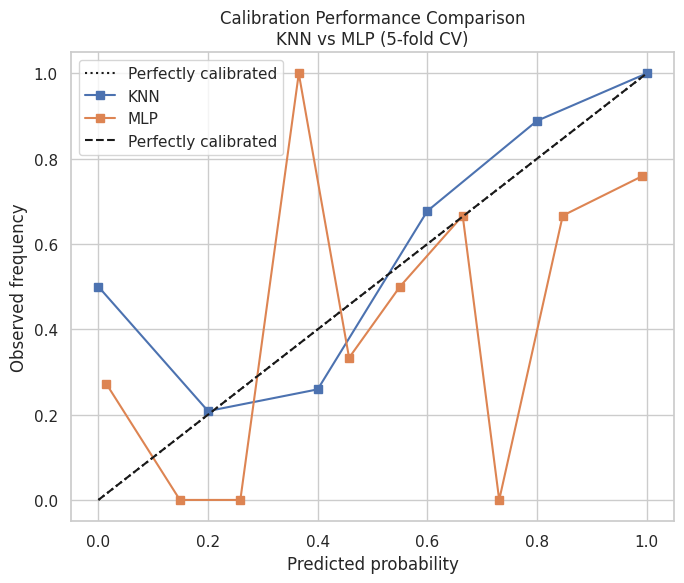

=== Brier Scores (lower is better) ===
KNN: 0.1686
MLP: 0.2413


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']

# Recode labels: 1 -> 0, 2 -> 1
y = y_raw.replace({1: 0, 2: 1})

print("Class counts:\n", y.value_counts(), "\n")

# 2. Define models (KNN and MLP) with scaling

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    ))
])

models = {
    "KNN": knn_pipe,
    "MLP": mlp_pipe
}

# 3. 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(7, 6))

brier_scores = {}

# 4. Get out-of-fold probabilities and plot calibration curves
for name, pipe in models.items():
    prob_pos = cross_val_predict(
        pipe,
        X,
        y,
        cv=cv,
        method="predict_proba"
    )[:, 1]
    
    # Brier score (lower is better)
    brier = brier_score_loss(y, prob_pos)
    brier_scores[name] = brier
    
    # Calibration curve
    CalibrationDisplay.from_predictions(
        y_true=y,
        y_prob=prob_pos,
        n_bins=10,
        name=name,
        ax=plt.gca()
    )

# Perfect calibration reference line
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.title("Calibration Performance Comparison\nKNN vs MLP (5-fold CV)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Print Brier scores
print("=== Brier Scores (lower is better) ===")
for name, b in brier_scores.items():
    print(f"{name}: {b:.4f}")


In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']

# Recode labels: 1 -> 0, 2 -> 1
y = y_raw.replace({1: 0, 2: 1})

# 2. Model (same KNN as before)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 3. 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tau = 0.1   # <-- only this tau

coverages = []
accuracies = []
recalls = []
precisions = []
briers = []

fold_id = 1

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    pipe.fit(X_train, y_train)
    
    proba = pipe.predict_proba(X_test)
    p_pos = proba[:, 1]
    
    # confidence = distance from 0.5
    conf = np.abs(p_pos - 0.5)
    
    # normal decision boundary at 0.5
    y_pred = (p_pos >= 0.5).astype(int)
    
    # selective rule for this tau
    mask = conf >= tau
    
    coverage = mask.mean()
    
    print(f"Fold {fold_id} - tau={tau}")
    print(f"  coverage = {coverage:.3f}")
    
    if coverage == 0:
        print("  (no selected samples in this fold)\n")
        fold_id += 1
        continue
    
    y_true_sel = y_test[mask]
    y_pred_sel = y_pred[mask]
    p_pos_sel  = p_pos[mask]
    
    acc = accuracy_score(y_true_sel, y_pred_sel)
    rec = recall_score(y_true_sel, y_pred_sel)
    prec = precision_score(y_true_sel, y_pred_sel)
    brier = brier_score_loss(y_true_sel, p_pos_sel)
    
    print(f"  accuracy  = {acc:.3f}")
    print(f"  recall    = {rec:.3f}")
    print(f"  precision = {prec:.3f}")
    print(f"  brier     = {brier:.3f}\n")
    
    coverages.append(coverage)
    accuracies.append(acc)
    recalls.append(rec)
    precisions.append(prec)
    briers.append(brier)
    
    fold_id += 1

def fmt(arr):
    arr = np.array(arr)
    return f"{arr.mean():.3f} ± {arr.std():.3f}"

print("=== Summary for tau = 0.1 (5-fold) ===")
print("Coverage (mean ± sd) :", fmt(coverages))
print("Accuracy (mean ± sd) :", fmt(accuracies))
print("Recall   (mean ± sd) :", fmt(recalls))
print("Precision(mean ± sd) :", fmt(precisions))
print("Brier    (mean ± sd) :", fmt(briers))


Fold 1 - tau=0.1
  coverage = 0.583
  accuracy  = 0.786
  recall    = 0.750
  precision = 0.857
  brier     = 0.186

Fold 2 - tau=0.1
  coverage = 0.478
  accuracy  = 1.000
  recall    = 1.000
  precision = 1.000
  brier     = 0.029

Fold 3 - tau=0.1
  coverage = 0.391
  accuracy  = 0.889
  recall    = 0.857
  precision = 1.000
  brier     = 0.084

Fold 4 - tau=0.1
  coverage = 0.696
  accuracy  = 0.812
  recall    = 0.750
  precision = 0.857
  brier     = 0.148

Fold 5 - tau=0.1
  coverage = 0.348
  accuracy  = 0.875
  recall    = 0.833
  precision = 1.000
  brier     = 0.105

=== Summary for tau = 0.1 (5-fold) ===
Coverage (mean ± sd) : 0.499 ± 0.127
Accuracy (mean ± sd) : 0.872 ± 0.074
Recall   (mean ± sd) : 0.838 ± 0.092
Precision(mean ± sd) : 0.943 ± 0.070
Brier    (mean ± sd) : 0.110 ± 0.054


In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

# 1. Load data once
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']
y = y_raw.replace({1: 0, 2: 1})   # 0/1 labels

# 2. Define model + pipeline once
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_for_tau(tau):
    coverages = []
    accuracies = []
    recalls = []
    precisions = []
    briers = []

    fold_id = 1

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)

        proba = pipe.predict_proba(X_test)
        p_pos = proba[:, 1]

        # confidence = distance from 0.5
        conf = np.abs(p_pos - 0.5)

        # normal decision boundary at 0.5
        y_pred = (p_pos >= 0.5).astype(int)

        # selective rule
        mask = conf >= tau

        coverage = mask.mean()
        print(f"Fold {fold_id} - tau={tau}")
        print(f"  coverage = {coverage:.3f}")

        if coverage == 0:
            print("  (no selected samples in this fold)\n")
            fold_id += 1
            continue

        y_true_sel = y_test[mask]
        y_pred_sel = y_pred[mask]
        p_pos_sel  = p_pos[mask]

        acc = accuracy_score(y_true_sel, y_pred_sel)
        rec = recall_score(y_true_sel, y_pred_sel)
        prec = precision_score(y_true_sel, y_pred_sel)
        brier = brier_score_loss(y_true_sel, p_pos_sel)

        print(f"  accuracy  = {acc:.3f}")
        print(f"  recall    = {rec:.3f}")
        print(f"  precision = {prec:.3f}")
        print(f"  brier     = {brier:.3f}\n")

        coverages.append(coverage)
        accuracies.append(acc)
        recalls.append(rec)
        precisions.append(prec)     # ✅ fixed: append prec, NOT precisions
        briers.append(brier)

        fold_id += 1

    def fmt(arr):
        arr = np.array(arr)
        return f"{arr.mean():.3f} ± {arr.std():.3f}"

    print(f"=== Summary for tau = {tau} (5-fold) ===")
    print("Coverage (mean ± sd) :", fmt(coverages))
    print("Accuracy (mean ± sd) :", fmt(accuracies))
    print("Recall   (mean ± sd) :", fmt(recalls))
    print("Precision(mean ± sd) :", fmt(precisions))
    print("Brier    (mean ± sd) :", fmt(briers))
    print()

# Now just call:
run_for_tau(0.1)
# then:
run_for_tau(0.2)
# then:
run_for_tau(0.3)


Fold 1 - tau=0.1
  coverage = 0.583
  accuracy  = 0.786
  recall    = 0.750
  precision = 0.857
  brier     = 0.186

Fold 2 - tau=0.1
  coverage = 0.478
  accuracy  = 1.000
  recall    = 1.000
  precision = 1.000
  brier     = 0.029

Fold 3 - tau=0.1
  coverage = 0.391
  accuracy  = 0.889
  recall    = 0.857
  precision = 1.000
  brier     = 0.084

Fold 4 - tau=0.1
  coverage = 0.696
  accuracy  = 0.812
  recall    = 0.750
  precision = 0.857
  brier     = 0.148

Fold 5 - tau=0.1
  coverage = 0.348
  accuracy  = 0.875
  recall    = 0.833
  precision = 1.000
  brier     = 0.105

=== Summary for tau = 0.1 (5-fold) ===
Coverage (mean ± sd) : 0.499 ± 0.127
Accuracy (mean ± sd) : 0.872 ± 0.074
Recall   (mean ± sd) : 0.838 ± 0.092
Precision(mean ± sd) : 0.943 ± 0.070
Brier    (mean ± sd) : 0.110 ± 0.054

Fold 1 - tau=0.2
  coverage = 0.583
  accuracy  = 0.786
  recall    = 0.750
  precision = 0.857
  brier     = 0.186

Fold 2 - tau=0.2
  coverage = 0.478
  accuracy  = 1.000
  recall    = 1.0

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# After loading X and y (0/1 labels)

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold probabilities (like ensemble_probs but for all data)
probs_knn = cross_val_predict(pipe_knn, X, y, cv=cv, method="predict_proba")[:, 1]

def selective_eval(y_true, p, tau):
    y = np.asarray(y_true)
    keep = np.abs(p - 0.5) >= tau
    if keep.sum() == 0:
        return {"tau": tau, "coverage": 0.0, "acc": np.nan, "recall": np.nan, "precision": np.nan}
    yhat = (p[keep] >= 0.5).astype(int)
    return {
        "tau": tau,
        "coverage": keep.mean(),
        "acc": accuracy_score(y[keep], yhat),
        "recall": recall_score(y[keep], yhat, pos_label=y.max()),
        "precision": precision_score(y[keep], yhat, pos_label=y.max())
    }

rows = [selective_eval(y, probs_knn, tau) for tau in np.linspace(0.00, 0.30, 16)]
sel_df = pd.DataFrame(rows)
print(sel_df)


     tau  coverage       acc    recall  precision
0   0.00       1.0  0.784483  0.796875   0.809524
1   0.02       1.0  0.784483  0.796875   0.809524
2   0.04       1.0  0.784483  0.796875   0.809524
3   0.06       1.0  0.784483  0.796875   0.809524
4   0.08       1.0  0.784483  0.796875   0.809524
5   0.10       0.5  0.862069  0.833333   0.937500
6   0.12       0.5  0.862069  0.833333   0.937500
7   0.14       0.5  0.862069  0.833333   0.937500
8   0.16       0.5  0.862069  0.833333   0.937500
9   0.18       0.5  0.862069  0.833333   0.937500
10  0.20       0.5  0.862069  0.833333   0.937500
11  0.22       0.5  0.862069  0.833333   0.937500
12  0.24       0.5  0.862069  0.833333   0.937500
13  0.26       0.5  0.862069  0.833333   0.937500
14  0.28       0.5  0.862069  0.833333   0.937500
15  0.30       0.5  0.862069  0.833333   0.937500


In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']
y = y_raw.replace({1: 0, 2: 1})   # 0/1 labels

# 2. Model + pipeline
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 3. 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_for_tau(tau):
    coverages = []
    accuracies = []
    recalls = []
    precisions = []
    briers = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)

        proba = pipe.predict_proba(X_test)
        p_pos = proba[:, 1]

        # confidence = distance from 0.5
        conf = np.abs(p_pos - 0.5)

        # normal decision boundary
        y_pred = (p_pos >= 0.5).astype(int)

        # selective rule
        mask = conf >= tau
        coverage = mask.mean()

        if coverage == 0:
            # no selected samples
            continue

        y_true_sel = y_test[mask]
        y_pred_sel = y_pred[mask]
        p_pos_sel  = p_pos[mask]

        acc   = accuracy_score(y_true_sel, y_pred_sel)
        rec   = recall_score(y_true_sel, y_pred_sel)
        prec  = precision_score(y_true_sel, y_pred_sel)
        brier = brier_score_loss(y_true_sel, p_pos_sel)

        coverages.append(coverage)
        accuracies.append(acc)
        recalls.append(rec)
        precisions.append(prec)
        briers.append(brier)

    def mean_sd(arr):
        arr = np.array(arr)
        return arr.mean(), arr.std()

    cov_m, cov_s = mean_sd(coverages)
    acc_m, acc_s = mean_sd(accuracies)
    rec_m, rec_s = mean_sd(recalls)
    prec_m, prec_s = mean_sd(precisions)
    br_m, br_s = mean_sd(briers)

    return {
        "τ": tau,
        "Coverage (mean ± sd)": f"{cov_m:.3f} ± {cov_s:.3f}",
        "Accuracy (mean ± sd)": f"{acc_m:.3f} ± {acc_s:.3f}",
        "Recall (mean ± sd)":   f"{rec_m:.3f} ± {rec_s:.3f}",
        "Precision (mean ± sd)":f"{prec_m:.3f} ± {prec_s:.3f}",
        "Brier (mean ± sd)":    f"{br_m:.3f} ± {br_s:.3f}",
    }

taus = [0.0, 0.1, 0.2, 0.3, 0.4]
rows = [eval_for_tau(tau) for tau in taus]

tau_df = pd.DataFrame(rows)
print(tau_df.to_string(index=False))


  τ Coverage (mean ± sd) Accuracy (mean ± sd) Recall (mean ± sd) Precision (mean ± sd) Brier (mean ± sd)
0.0        1.000 ± 0.000        0.784 ± 0.073      0.797 ± 0.035         0.821 ± 0.090     0.168 ± 0.025
0.1        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.2        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.3        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.4        0.138 ± 0.050        0.950 ± 0.100      0.950 ± 0.100         1.000 ± 0.000     0.050 ± 0.100


In [33]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']
y = y_raw.replace({1: 0, 2: 1})   # 0/1 labels

# 2. Model + pipeline (KNN)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 3. 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_for_tau(tau):
    coverages = []
    accuracies = []
    recalls = []
    precisions = []
    briers = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe.fit(X_train, y_train)

        proba = pipe.predict_proba(X_test)
        p_pos = proba[:, 1]

        # confidence = distance from 0.5
        conf = np.abs(p_pos - 0.5)

        # normal decision boundary
        y_pred = (p_pos >= 0.5).astype(int)

        # selective rule
        mask = conf >= tau
        coverage = mask.mean()

        if coverage == 0:
            continue  # skip if no selected samples

        y_true_sel = y_test[mask]
        y_pred_sel = y_pred[mask]
        p_pos_sel  = p_pos[mask]

        acc   = accuracy_score(y_true_sel, y_pred_sel)
        rec   = recall_score(y_true_sel, y_pred_sel)
        prec  = precision_score(y_true_sel, y_pred_sel)
        brier = brier_score_loss(y_true_sel, p_pos_sel)

        coverages.append(coverage)
        accuracies.append(acc)
        recalls.append(rec)
        precisions.append(prec)
        briers.append(brier)

    def mean_sd(arr):
        arr = np.array(arr)
        return arr.mean(), arr.std()

    cov_m, cov_s = mean_sd(coverages)
    acc_m, acc_s = mean_sd(accuracies)
    rec_m, rec_s = mean_sd(recalls)
    prec_m, prec_s = mean_sd(precisions)
    br_m, br_s = mean_sd(briers)

    return {
        "τ": tau,
        "Coverage (mean ± sd)": f"{cov_m:.3f} ± {cov_s:.3f}",
        "Accuracy (mean ± sd)": f"{acc_m:.3f} ± {acc_s:.3f}",
        "Recall (mean ± sd)":   f"{rec_m:.3f} ± {rec_s:.3f}",
        "Precision (mean ± sd)":f"{prec_m:.3f} ± {prec_s:.3f}",
        "Brier (mean ± sd)":    f"{br_m:.3f} ± {br_s:.3f}",
    }

# 4. Your chosen tau values
taus = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.4, 0.6]
rows = [eval_for_tau(tau) for tau in taus]

tau_df = pd.DataFrame(rows)
print(tau_df.to_string(index=False))


   τ Coverage (mean ± sd) Accuracy (mean ± sd) Recall (mean ± sd) Precision (mean ± sd) Brier (mean ± sd)
0.02        1.000 ± 0.000        0.784 ± 0.073      0.797 ± 0.035         0.821 ± 0.090     0.168 ± 0.025
0.05        1.000 ± 0.000        0.784 ± 0.073      0.797 ± 0.035         0.821 ± 0.090     0.168 ± 0.025
0.10        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.15        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.20        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.25        0.499 ± 0.127        0.872 ± 0.074      0.838 ± 0.092         0.943 ± 0.070     0.110 ± 0.054
0.40        0.138 ± 0.050        0.950 ± 0.100      0.950 ± 0.100         1.000 ± 0.000     0.050 ± 0.100
0.60            nan ± nan            nan ± nan          nan ± nan             nan ± nan         nan ± nan


/tmp/ipykernel_13/3525956462.py:74: RuntimeWarning: Mean of empty slice.
  return arr.mean(), arr.std()
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


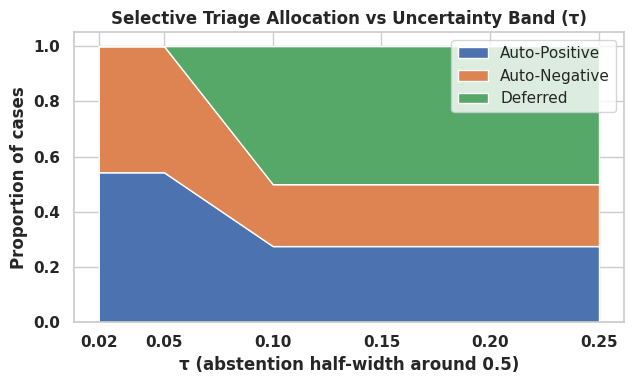

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Make sure X and y_bin are already defined, e.g.:
# X = df.drop(columns=['Classification'])
# y_bin = df['Classification'].replace({1: 0, 2: 1})

# 1. Define model and pipeline (KNN as in your findings)
base_clf = KNeighborsClassifier(n_neighbors=5)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', base_clf)
])

# 2. Get out-of-fold predicted probabilities using 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

probs = cross_val_predict(
    pipe,
    X,
    y_bin,
    cv=cv,
    method="predict_proba"
)

# Probability of positive class
p = probs[:, 1]

# Hard predictions at 0.5 threshold
yhat = (p >= 0.5).astype(int)

# 3. Use your τ values
taus = np.array([0.02, 0.05, 0.10, 0.15, 0.20, 0.25])

auto_pos, auto_neg, deferred = [], [], []

for tau in taus:
    # Keep only high-confidence predictions: |p - 0.5| >= τ
    keep = np.abs(p - 0.5) >= tau

    # Proportion of all cases that are:
    # - auto-labeled positive
    # - auto-labeled negative
    # - deferred (no decision)
    auto_pos.append(((keep) & (yhat == 1)).mean())
    auto_neg.append(((keep) & (yhat == 0)).mean())
    deferred.append((~keep).mean())

# 4. Plot stackplot
plt.figure(figsize=(6.5, 4))
plt.stackplot(taus, auto_pos, auto_neg, deferred,
              labels=['Auto-Positive', 'Auto-Negative', 'Deferred'])

plt.title('Selective Triage Allocation vs Uncertainty Band (τ)', fontweight='bold')
plt.xlabel('τ (abstention half-width around 0.5)', fontweight='bold')
plt.ylabel('Proportion of cases', fontweight='bold')
plt.xticks(taus, [f"{t:.2f}" for t in taus], fontweight='bold')
plt.yticks(fontweight='bold')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    brier_score_loss
)

# Assuming you already have:
# df = pd.read_csv(...)
# X = df.drop(columns=['Classification'])
# y_raw = df['Classification']

# Recode labels to 0 and 1
y = y_raw.replace({1: 0, 2: 1})

# Define MLP and pipeline (same as before)
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', mlp)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics per fold
metrics = {
    "acc": [],
    "prec_c0": [], "prec_c1": [], "prec_macro": [], "prec_weighted": [],
    "rec_c0": [], "rec_c1": [], "rec_macro": [], "rec_weighted": [],
    "f1_c0": [], "f1_c1": [], "f1_macro": [], "f1_weighted": [],
    "brier": []
}

# Loop over folds
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]  # probability of class 1
    
    # Accuracy
    metrics["acc"].append(accuracy_score(y_test, y_pred))
    
    # Precision
    metrics["prec_c0"].append(precision_score(y_test, y_pred, pos_label=0))
    metrics["prec_c1"].append(precision_score(y_test, y_pred, pos_label=1))
    metrics["prec_macro"].append(precision_score(y_test, y_pred, average='macro'))
    metrics["prec_weighted"].append(precision_score(y_test, y_pred, average='weighted'))
    
    # Recall
    metrics["rec_c0"].append(recall_score(y_test, y_pred, pos_label=0))
    metrics["rec_c1"].append(recall_score(y_test, y_pred, pos_label=1))
    metrics["rec_macro"].append(recall_score(y_test, y_pred, average='macro'))
    metrics["rec_weighted"].append(recall_score(y_test, y_pred, average='weighted'))
    
    # F1
    metrics["f1_c0"].append(f1_score(y_test, y_pred, pos_label=0))
    metrics["f1_c1"].append(f1_score(y_test, y_pred, pos_label=1))
    metrics["f1_macro"].append(f1_score(y_test, y_pred, average='macro'))
    metrics["f1_weighted"].append(f1_score(y_test, y_pred, average='weighted'))
    
    # Brier score (overall, for class 1 probability)
    metrics["brier"].append(brier_score_loss(y_test, y_proba))

# Helper to format mean ± sd
def fmt(key):
    arr = np.array(metrics[key])
    return f"{arr.mean():.4f} ± {arr.std():.4f}"

print("=== MLP (5-fold Stratified CV) – per-class metrics (mean ± SD) ===\n")

print("Accuracy:", fmt("acc"), "\n")

print("Precision:")
print("  Class 0      :", fmt("prec_c0"))
print("  Class 1      :", fmt("prec_c1"))
print("  Macro avg    :", fmt("prec_macro"))
print("  Weighted avg :", fmt("prec_weighted"), "\n")

print("Recall:")
print("  Class 0      :", fmt("rec_c0"))
print("  Class 1      :", fmt("rec_c1"))
print("  Macro avg    :", fmt("rec_macro"))
print("  Weighted avg :", fmt("rec_weighted"), "\n")

print("F1-score:")
print("  Class 0      :", fmt("f1_c0"))
print("  Class 1      :", fmt("f1_c1"))
print("  Macro avg    :", fmt("f1_macro"))
print("  Weighted avg :", fmt("f1_weighted"), "\n")

print("Brier score (overall):", fmt("brier"))


=== MLP (5-fold Stratified CV) – per-class metrics (mean ± SD) ===

Accuracy: 0.7156 ± 0.0973 

Precision:
  Class 0      : 0.6978 ± 0.1230
  Class 1      : 0.7242 ± 0.0887
  Macro avg    : 0.7110 ± 0.1048
  Weighted avg : 0.7127 ± 0.1025 

Recall:
  Class 0      : 0.6145 ± 0.1683
  Class 1      : 0.7962 ± 0.0639
  Macro avg    : 0.7053 ± 0.1045
  Weighted avg : 0.7156 ± 0.0973 

F1-score:
  Class 0      : 0.6501 ± 0.1520
  Class 1      : 0.7571 ± 0.0739
  Macro avg    : 0.7036 ± 0.1102
  Weighted avg : 0.7098 ± 0.1051 

Brier score (overall): 0.2413 ± 0.0839


KNN Brier score: 0.1686
MLP Brier score: 0.2413


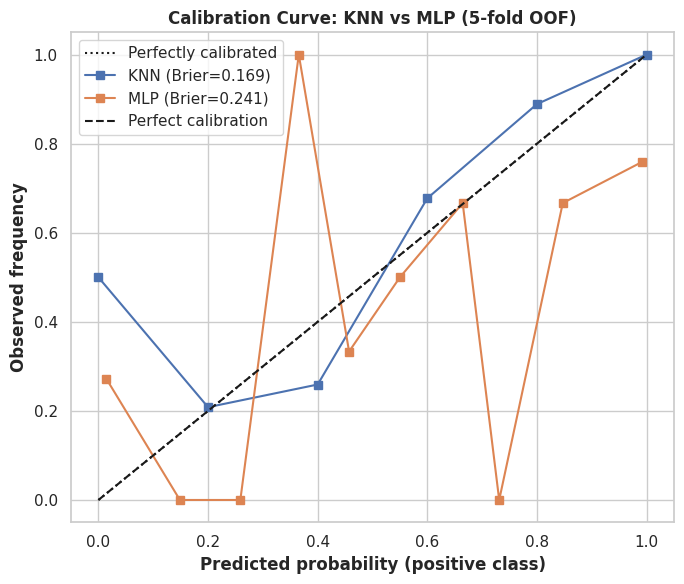

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

# 1. Load data (if not already loaded)
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']
y_bin = y_raw.replace({1: 0, 2: 1})   # 0 = class 1, 1 = class 2

# 2. Define models with scaling
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Get out-of-fold probabilities
probs_knn = cross_val_predict(knn_pipe, X, y_bin, cv=cv, method="predict_proba")[:, 1]
probs_mlp = cross_val_predict(mlp_pipe, X, y_bin, cv=cv, method="predict_proba")[:, 1]

# 4. Compute Brier scores
brier_knn = brier_score_loss(y_bin, probs_knn)
brier_mlp = brier_score_loss(y_bin, probs_mlp)

print(f"KNN Brier score: {brier_knn:.4f}")
print(f"MLP Brier score: {brier_mlp:.4f}")

# 5. Plot calibration curves
plt.figure(figsize=(7, 6))

CalibrationDisplay.from_predictions(
    y_true=y_bin,
    y_prob=probs_knn,
    n_bins=10,
    name=f"KNN (Brier={brier_knn:.3f})",
    ax=plt.gca()
)

CalibrationDisplay.from_predictions(
    y_true=y_bin,
    y_prob=probs_mlp,
    n_bins=10,
    name=f"MLP (Brier={brier_mlp:.3f})",
    ax=plt.gca()
)

# Perfect calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")

plt.title("Calibration Curve: KNN vs MLP (5-fold OOF)", fontweight='bold')
plt.xlabel("Predicted probability (positive class)", fontweight='bold')
plt.ylabel("Observed frequency", fontweight='bold')
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


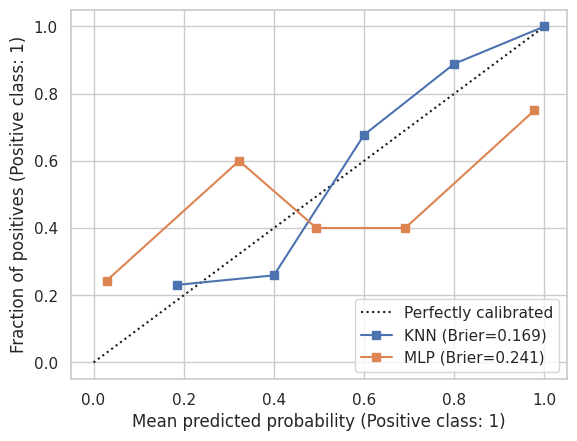

In [37]:
CalibrationDisplay.from_predictions(
    y_true=y_bin,
    y_prob=probs_knn,
    n_bins=5,
    name=f"KNN (Brier={brier_knn:.3f})",
    ax=plt.gca()
)

CalibrationDisplay.from_predictions(
    y_true=y_bin,
    y_prob=probs_mlp,
    n_bins=5,
    name=f"MLP (Brier={brier_mlp:.3f})",
    ax=plt.gca()
)


KNN Brier score: 0.1686
MLP Brier score: 0.2413


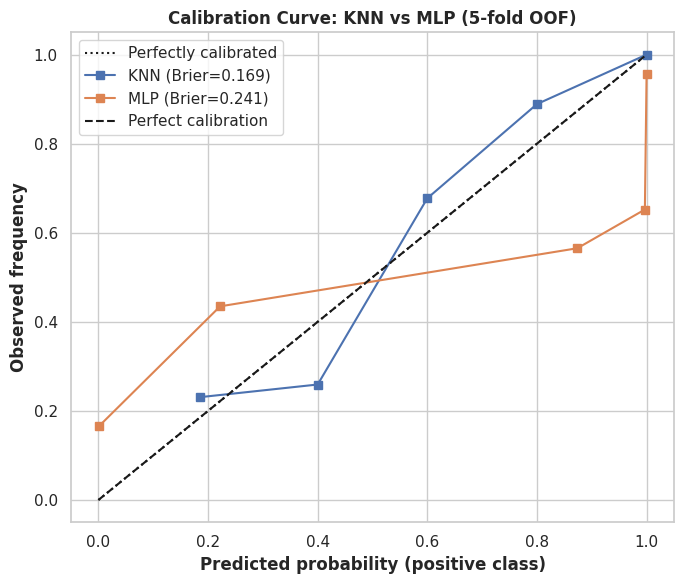

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

# 1. Load data
df = pd.read_csv("/kaggle/input/coimbra-breastcancer/Coimbra_breast_cancer_dataset.csv")

X = df.drop(columns=['Classification'])
y_raw = df['Classification']
y_bin = y_raw.replace({1: 0, 2: 1})   # 0 = class 1, 1 = class 2

# 2. Define models with scaling
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Get out-of-fold probabilities
probs_knn = cross_val_predict(knn_pipe, X, y_bin, cv=cv, method="predict_proba")[:, 1]
probs_mlp = cross_val_predict(mlp_pipe, X, y_bin, cv=cv, method="predict_proba")[:, 1]

# 4. Compute Brier scores
brier_knn = brier_score_loss(y_bin, probs_knn)
brier_mlp = brier_score_loss(y_bin, probs_mlp)

print(f"KNN Brier score: {brier_knn:.4f}")
print(f"MLP Brier score: {brier_mlp:.4f}")

# 5. Plot calibration curves
plt.figure(figsize=(7, 6))

CalibrationDisplay.from_predictions(
    y_true=y_bin,
    y_prob=probs_knn,
    n_bins=5,                 # you can change to 10 if you prefer
    strategy="quantile",      # or remove this line if you want equal-width bins
    name=f"KNN (Brier={brier_knn:.3f})",
    ax=plt.gca()
)

CalibrationDisplay.from_predictions(
    y_true=y_bin,
    y_prob=probs_mlp,
    n_bins=5,
    strategy="quantile",
    name=f"MLP (Brier={brier_mlp:.3f})",
    ax=plt.gca()
)

# Perfect calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")

plt.title("Calibration Curve: KNN vs MLP (5-fold OOF)", fontweight='bold')
plt.xlabel("Predicted probability (positive class)", fontweight='bold')

# 🔴 Change y-axis label here:
plt.ylabel("Observed frequency", fontweight='bold')

plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
